<a href="https://colab.research.google.com/github/Rogercaste/Bachelor_thesis/blob/main/Colormaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import random as rand
import time



In [5]:
class Simulation:
    def __init__(self, mu, sigma, tau_o, **p_kwargs):
        # Parameters of the simulation
        self.e0 = 2.5  
        self.r = 0.56
        self.u0 = 6
        self.tau_e = 0.01
        self.tau_i = 0.02
        self.tau_o = tau_o
        self.D = 2500*self.tau_o
        self.gamma_e = 0.0325
        self.gamma_i = 0.44
        self.mu = mu
        self.sigma = sigma 
  
        
        self.C1, self.C2, self.C3, self.C4 = 135,108,33.75,33.75

        #numerical parameters
        self.runtime = 60
        self.dt = 0.0001
        self.t_arr = np.linspace(0, self.runtime, int(self.runtime/self.dt))

        #run some code
        var = np.zeros((7, int(self.runtime/self.dt)))
        var[:,0] = 0.1, 17, 12, 0, 0, 0, 0
        self.generate_p(mu, sigma, **p_kwargs)
        self.euler(var,mu,sigma)

    def tf(self, u):
        firing_r = 2*self.e0/(1+np.exp(self.r*(self.u0-u)))
        return firing_r
    
    def jansen_rit(self, var, p_t, mu):
        s1,s2,s3 = var[0],var[1],var[2]
        Z1,Z2,Z3,O = var[3],var[4],var[5],var[6]

        ds1 = Z1/self.tau_e
        dZ1 = (1/self.tau_e)*(self.gamma_e*self.tf(s2-s3)-2*Z1-s1)

        ds2 = Z2/self.tau_e
        dZ2 = (1/self.tau_e)*(self.gamma_e*( mu + O + self.C2*self.tf(self.C1*s1)) -2*Z2 - s2)
        #dZ2 = (1/self.tau_e)*(self.gamma_e*(p_t + self.C2*self.tf(self.C1*s1)) -2*Z2 - s2)
        
        ds3 = Z3/self.tau_i
        dZ3 = (1/self.tau_i)*(self.gamma_i*self.C4*self.tf(self.C3*s1) -2*Z3 - s3)
        
        dO = -O/self.tau_o  

        return ds1, ds2, ds3, dZ1, dZ2, dZ3, dO

    def euler(self, var, mu, sigma):
        for i in range(len(self.t_arr)-1):
            ds1, ds2, ds3, dZ1, dZ2, dZ3, dO = self.jansen_rit(var[:,i], self.p_t[i], mu)
            var[0,i+1] = ds1*self.dt + var[0,i]
            var[1,i+1] = ds2*self.dt + var[1,i]
            var[2,i+1] = ds3*self.dt + var[2,i]
            var[3,i+1] = dZ1*self.dt + var[3,i]
            var[4,i+1] = dZ2*self.dt + var[4,i]
            var[5,i+1] = dZ3*self.dt + var[5,i]
            var[6,i+1] = dO *self.dt + var[6,i] + (np.sqrt(2*self.D)/self.tau_o)*rand.gauss(0, sigma*np.sqrt(self.dt))
        
        self.voltage = var[1,:] - var[2,:]
        return var
    
    def generate_p(self, mu, sigma, **p_kwargs):
        if p_kwargs['usebutter']: #wether we should lowpass p signal
            p = np.random.normal(mu, sigma, int(self.runtime/self.dt))
            sos = signal.butter(p_kwargs['order'], p_kwargs['cutoff'], 'low', fs=int(1/self.dt), output='sos')
            self.p_t = signal.sosfilt(sos, p)

        else:
            noise_signal = []
            counter = 0
            current_noise = np.random.normal(mu, sigma)
            for i in range(len(self.t_arr)):
                if counter == p_kwargs['counter']:
                    current_noise = np.random.normal(mu, sigma)
                    counter = 0
                noise_signal.append(current_noise)
                counter += 1
            self.p_t = list(noise_signal)   

    def count_ripples(self):
        self.analysis = SimulationAnalysis(self.t_arr, self.voltage)
        self.analysis.generate_sharpwave_regime()
        return self.analysis.ripple_count()

    def plot(self):
        plt.figure(figsize=(10, 4))
        plt.plot(self.t_arr, self.voltage, label='s2-s3 vs t')
        plt.legend()
        plt.title(f"mu={self.mu}, sigma= {self.sigma}")
        
    



In [6]:
class SimulationAnalysis:
    def __init__(self, time, voltage):
        #time and and voltage are arrays like in the plot with sharp waves
        self.time=time
        self.voltage= voltage
    
    def generate_sharpwave_regime(self, period=0.2, threshold_voltage=3.5):
        sharpwave = False
        regimechange_t = 0
        self.sharpwave_regime = np.zeros(len(self.time))
        for ind, t in enumerate (self.time):
            if sharpwave == False:
                if self.voltage[ind] < threshold_voltage: 
                    sharpwave = True
                    regimechange_t = 0 
                    self.sharpwave_regime[ind] = 1.0
            else:
                if self.voltage[ind] < threshold_voltage:
                    self.sharpwave_regime[ind] = 1.0
                    regimechange_t = 0
                elif regimechange_t < period:
                    self.sharpwave_regime[ind] = 1
                    regimechange_t += self.time[1] - self.time[0]
                else:
                    sharpwave = False
                    

        
    def plot_sharpwave_regime(self):
        plt.figure()
        plt.plot(self.time, self.sharpwave_regime)
        plt.show()
    def ripple_count(self):
        self.sharpwave_regime = list(self.sharpwave_regime)
        #self.sharpwave_regime=[int(element) for element in self.sharpwave_regime]
        count = 0  
        ir_time= 0
        ir_times = []
        r_coords = []
        for i in range(len(self.sharpwave_regime) - 1):
            if self.sharpwave_regime[i] == 1. and self.sharpwave_regime[i+1] == 0.:
                count += 1
                ir_times.append(ir_time)
                ir_time = 0
                r_coords.append(i)
                
            else:
                ir_time += 1
        r_coords = [ x/(10**4) for x in r_coords]
        return count, np.std(ir_times), r_coords


In [7]:
def generate_colormap(tau_o, n_mu, n_sigma, sigma_start, sigma_end, mu_start, mu_end, n_simulations,**p_kwargs):
    mu_arr = np.linspace(mu_start, mu_end, n_mu, endpoint=True)
    sigma_arr = np.linspace(sigma_start, sigma_end, n_sigma, endpoint=True)

    observed_ripples_mesh = np.empty((len(mu_arr), len(sigma_arr)))
    observed_std_ir_mesh = np.empty((len(mu_arr), len(sigma_arr)))
    
    for i in range(n_simulations):
        for sigma_ind, sigma in enumerate(sigma_arr):
            for mu_ind, mu in enumerate(mu_arr):
                print(i)
                simulation = Simulation(mu, sigma, tau_o ,**p_kwargs)
                analysiss = SimulationAnalysis(simulation.t_arr, simulation.voltage)
                result =simulation.count_ripples()
                observed_ripples_mesh[sigma_ind,mu_ind] = result[0]
                observed_std_ir_mesh[sigma_ind,mu_ind]= result [1]
                if i==(len(range(n_simulations))-1) or i==0:
                    if mu==mu_arr[0] or mu==mu_arr[-1]:
                        if sigma == sigma_arr[0] or sigma==sigma_arr[-1]:
                            plt.figure(figsize=(10, 4))
                            plt.plot(simulation.t_arr, simulation.voltage, label='s2-s3 vs t',linewidth=0.75)
                            plt.legend()
                            plt.title(f"mu={mu}, sigma= {sigma}")
                            plt.vlines(result[2], ymin=min(simulation.voltage)-2, ymax=max(simulation.voltage)+2, color='red', linewidth=0.8)
                            plt.show()
        
                    
        if i>0:
            observed_ripples_mesh_avg += observed_ripples_mesh
        else:
            observed_ripples_mesh_avg = observed_ripples_mesh
    observed_ripples_mesh_avg /= n_simulations
        
    plt.figure(dpi=200)
    plt.pcolormesh(mu_arr, sigma_arr, observed_ripples_mesh_avg)
    
    if p_kwargs["usebutter"] == False:
        plt.title(f"Ripplecount plot with count={p_kwargs['counter']}")
    else:
        plt.title(f"Ripplecount plot with order={p_kwargs['order']} , $F_c$={p_kwargs['cutoff']},  ")
    plt.axis()
    plt.colorbar()
    plt.xlabel('mu[Hz]' )
    plt.ylabel('sigma [Hz]')
    plt.show()
    
    plt.figure(dpi=200)
    plt.pcolormesh(mu_arr, sigma_arr, observed_std_ir_mesh)
    plt.axis()
    plt.colorbar()
    plt.xlabel('mu[Hz]' )
    plt.ylabel('sigma [Hz]')
    plt.show()
    
    
p_kwargs = {'usebutter' : False,\
            'counter' : 200,\
            'order': 10,\
            'cutoff': 50
            }


0


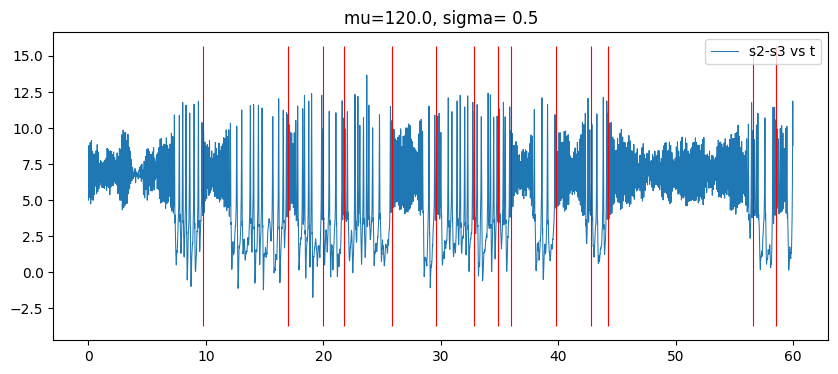

0
0
0


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


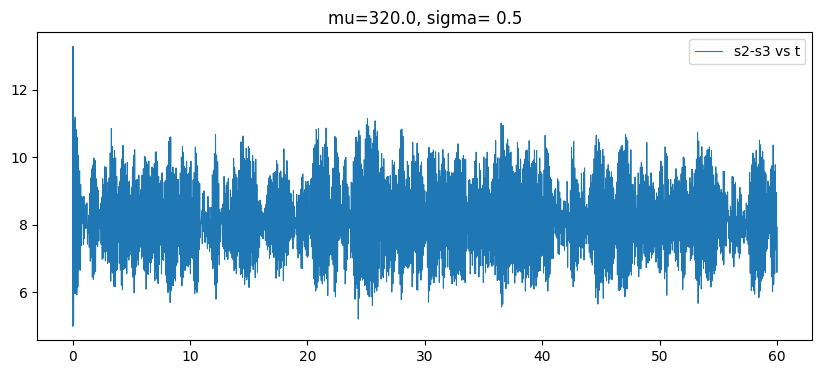

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


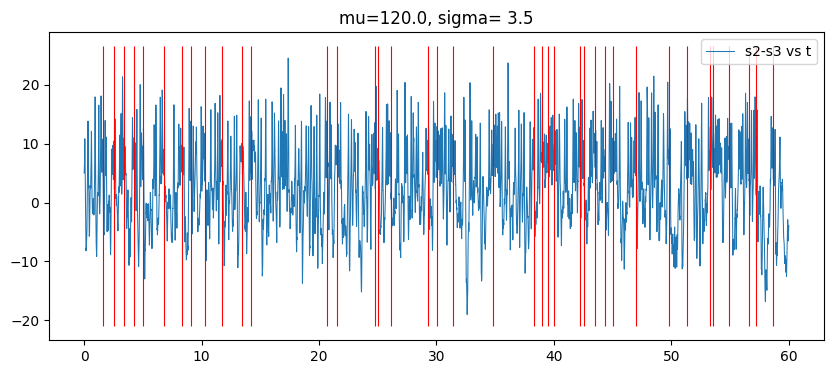

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


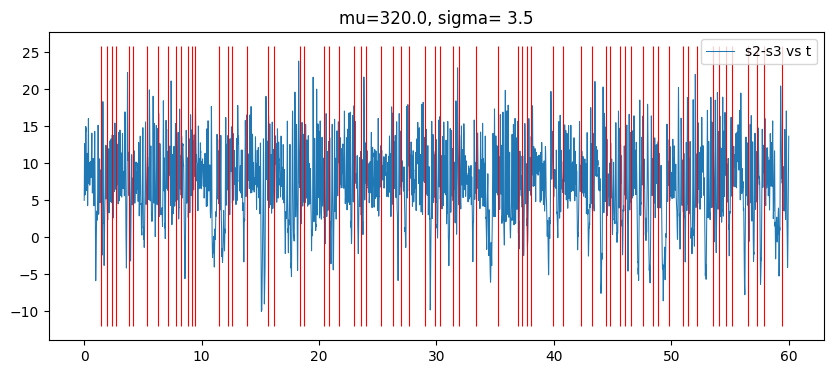

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [ ]:
start_time = time.time()

generate_colormap(tau_o=10**(-1),n_mu=20, n_sigma=20, sigma_start=0.5, sigma_end=3.5, mu_start=120, mu_end=320, n_simulations=20, **p_kwargs)
generate_colormap(tau_o=10**(-0.5),n_mu=20, n_sigma=20, sigma_start=0.5, sigma_end=3.5, mu_start=120, mu_end=320, n_simulations=20, **p_kwargs)
generate_colormap(tau_o=1,n_mu=20, n_sigma=20, sigma_start=0.5, sigma_end=3.5, mu_start=120, mu_end=320, n_simulations=20, **p_kwargs)

end_time = time.time()
runtime = end_time - start_time
print("Runtime: {:.2f} seconds".format(runtime))